writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model sandbox...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd-1...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 40 based on size of stress_period_data
    writing package wel-1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package sto...
    writing package oc...
FloPy is using the following executable to run the model: ..\..\..\..\mf6\windows\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.1 02/10/2025

   MODFLOW 6 compiled Feb 10 2025 17:37:25 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
    

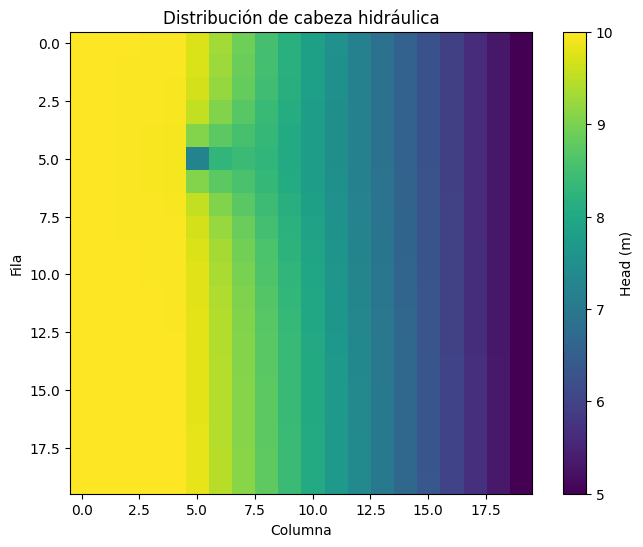

In [1]:
import flopy
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Configuración general ---
model_name = "sandbox"
sim_ws = "./mf6_sandbox"

sim = flopy.mf6.MFSimulation(
    sim_name=model_name,
    version="mf6",
    exe_name='../../../mf6/windows/mf6',
    sim_ws=sim_ws
)

# --- 2. Tiempos de simulación ---
tdis = flopy.mf6.ModflowTdis(
    sim,
    time_units="DAYS",
    nper=5,
    perioddata=[(2.0, 10, 1.0)] * 5,  # 5 periodos de 2 días cada uno
)


# --- 3. Solucionador numérico (IMS) ---
ims = flopy.mf6.ModflowIms(
    sim,
    print_option="SUMMARY",
    complexity="SIMPLE",
    outer_dvclose=1e-4,
    outer_maximum=50,
    under_relaxation="NONE",
    linear_acceleration="CG",
    inner_maximum=30,
    inner_dvclose=1e-6,
)
# Nota: la solución se enlazará al modelo más adelante

# --- 4. Modelo GWF ---
gwf = flopy.mf6.ModflowGwf(
    sim,
    modelname=model_name,
    model_nam_file=f"{model_name}.nam",
    save_flows=True
)

# --- 5. Grid del modelo ---
nlay, nrow, ncol = 1, 20, 20
delr = delc = 1.0
top = 0.0
botm = -1.0

dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)

# --- 6. Propiedades hidráulicas ---
ic = flopy.mf6.ModflowGwfic(
    gwf,
    strt=10.0  # condición inicial
)

# --- 6. Propiedades hidráulicas (heterogéneas) ---

# Creamos un arreglo de conductividad hidráulica para toda la grilla
k_array = np.ones((nlay, nrow, ncol))  # Inicializamos con 1.0

# Asignamos una conductividad baja en la mitad derecha del dominio
k_array[:, :, 5:] = 0.01  # columnas 5 a 9

# Creamos el paquete NPF usando esta matriz heterogénea
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    save_flows=True,
    icelltype=1,  # flujo a través del techo de las celdas
    k=k_array
)

# --- 7. Condiciones de frontera (BCF) ---
# Izquierda (col=0): cabeza fija a 10
# Derecha (col=9): cabeza fija a 5
chd_data = []
for row in range(nrow):
    chd_data.append([(0, row, 0), 10.0])
    chd_data.append([(0, row, ncol - 1), 5.0])

chd = flopy.mf6.ModflowGwfchd(
    gwf,
    stress_period_data=chd_data,
    pname="CHD-1",
    save_flows=True,
)

# --- 7b. Pozo de extracción ---

# --- Paquete WEL: Pozo de extracción en todos los periodos ---

wel_spd = {}
for per in range(5):  # para cada uno de los 5 periodos
    wel_spd[per] = [((0, 5, 5), -0.1)]  # extracción constante

wel = flopy.mf6.ModflowGwfwel(
    gwf,
    stress_period_data=wel_spd,
    pname="WEL-1",
    save_flows=True,
)

# Almacenamiento
sto = flopy.mf6.ModflowGwfsto(
    gwf,
    save_flows=True,
    iconvert=1,
    ss=1e-5,
    sy=0.15,
    steady_state={0: False},  # todos los periodos son transitorios
    transient={0: True}
)

# --- 8. Presiones y cabezas ---
head = flopy.mf6.ModflowGwfoc(
    gwf,
    budget_filerecord=f"{model_name}.cbc",
    head_filerecord=f"{model_name}.hds",
    saverecord=[("HEAD", "ALL")],
    printrecord=[("HEAD", "ALL")]
)

# --- 9. Registrar solución numérica al modelo ---
sim.register_solution_package(ims, [gwf.name])

# --- 10. Ejecutar ---
sim.write_simulation()
sim.run_simulation()

# --- 11. Leer resultados ---
headfile = f"{sim_ws}/{model_name}.hds"
hds = flopy.utils.HeadFile(headfile)
head = hds.get_data()

# --- 12. Visualizar ---
plt.figure(figsize=(8, 6))
plt.imshow(head[0], cmap="viridis", origin="upper")
plt.colorbar(label="Head (m)")
plt.title("Distribución de cabeza hidráulica")
plt.xlabel("Columna")
plt.ylabel("Fila")
plt.show()


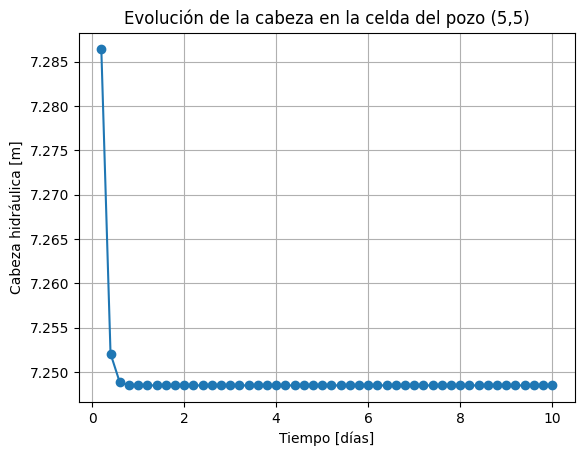

In [2]:

hds = flopy.utils.HeadFile(f"{sim_ws}/{model_name}.hds")
times = hds.get_times()
head_ts = [hds.get_data(totim=t)[0, 5, 5] for t in times]

plt.plot(times, head_ts, marker="o")
plt.title("Evolución de la cabeza en la celda del pozo (5,5)")
plt.xlabel("Tiempo [días]")
plt.ylabel("Cabeza hidráulica [m]")
plt.grid()
plt.show()